# QQ-plots

### Import modules

In [1]:
%matplotlib inline
import re
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import glob

### Read the dataframe and prepare it

In [13]:
# path plots output
base="../../../" 
path_output_plots = os.path.join(base,"plots","Figure5")
# path output methods
output_base = os.path.join(base,"data","output_methods_selection")
output_fmdeg_tcga_pan = os.path.join(output_base,"output_fmdeg_degrons_paper_tcga_penta","PAN-fmdeg.tsv")
output_smdeg_tcga_pan = os.path.join(output_base,"output_smdeg_degrons_paper_tcga_predicted_penta","PAN-smdeg.tsv")
# configuration of the typ eof plot
type_dict = {"SIM":{"P_VALUE":"PVALUE","MUTS":"OBSERVED_REGION","GENE_ID":"HUGO_SYMBOL"},"FM":{"P_VALUE":"P_VALUE","MUTS":"observed_mapped","GENE_ID":"GENE_ID"}}
type_run = "FM"

In [14]:
if type_run=="FM":
    df = pd.read_csv(output_fmdeg_tcga_pan,sep="\t")
else:
    df = pd.read_csv(output_smdeg_tcga_pan,sep="\t")
df=df[np.isfinite(df["P_VALUE"])]

In [15]:
class QQplot:
    
    def __init__(self, df, ttype,frac=0.10,  output_file=None):
        """Initialize the QQplot class.
        :param input_file: path, pat of the results file
        :param output: path or boolean, if True saves the plot to an output file
        :return: None
        """
        self.df = df
        self.frac = frac
        self.ttype = ttype
        self.output_file = output_file
        self._create_qqplots()
        
    @staticmethod
    def assign_color(line):
            return 'black'
    
    def _create_qqplots(self, ):
        """Create a QQplot.
        :return: None
        """
        df = self.df
        tumor_name = self.ttype
        method = "P_VALUE"
        fig = plt.figure(figsize=(6, 6))  # 20, 20
        ax = plt.subplot2grid((1, 1), (0, 0))
        
        
        
        data = df[[type_dict[type_run]["GENE_ID"], method]].copy()
        data = data[np.isfinite(data[method])]

        if len(data) == 0:
            return None
        # Reduce to less number of points
        kept = data[data[method]<0.1]
        random = data[data[method]>0.1]
        random = random.sample(frac=self.frac)
        print (random.shape)
        data = pd.concat([kept,random])
        
        # Calculate the minimum p-value
        min_pvalue = float(np.min(data[data[method] > 0][[method]]))
        data['OBS'] = data[method].map(lambda x: -np.log10(x) if x > 0 else -np.log10(min_pvalue))
        data.sort_values(by=['OBS'], inplace=True)
        exp_pvalues = -np.log10(np.arange(1, len(data) + 1) / float(len(data)))
        exp_pvalues.sort()
        data['EXP'] = exp_pvalues

        # Annotate genes. Color: black: KFP, green: KTP, orange: UNKNOWN 
        data['color'] = data.apply(self.assign_color, axis=1)

        # Get the maximum pvalues (observed and expected)
        max_x, max_y = 0, 0
        max_x = max(max_x, float(data[['EXP']].apply(np.max)))
        max_y = max(max_y, float(data[['OBS']].apply(np.max)))

        # Plot the data: first UNKNOWN, then KFP and finally KTP
        for color in ('orange', ):
            d = data[data['color'] == color].copy()
            d['i'] = range(len(d))
            d = d[(d['EXP'] > 2) | (d['i'] % 10 == 0)].copy()
            if len(d) > 0:
                ax.scatter(
                    d['EXP'].tolist(),
                    d['OBS'].tolist(),
                    color=color,
                    alpha=0.7,
                    s=30  # 500
                )
            print(len(d))

        for color in ('black', 'green'):
            d = data[data['color'] == color].copy()
            if len(d) > 0:
                ax.scatter(
                    d['EXP'].tolist(),
                    d['OBS'].tolist(),
                    color=color,
                    alpha=0.7,
                    s=30  # 500
                )
            print(len(d))

        # Give some extra space (+-5%)
        min_x = max_x * -0.05
        min_y = max_y * -0.05
        max_x *= 1.1
        max_y *= 1.1

        # Add labels
        ax.set_xlabel(r"Expected pvalues $(-\log_{10})$", fontsize=16)
        ax.set_ylabel(r"Observed pvalues $(-\log_{10})$", fontsize=16)

        # Make the tick label bigger
        ax.tick_params(labelsize=14)  # 42

        # Add the dashed diagonal
        ax.plot(
            np.linspace(0, np.floor(max(max_x, max_y))),
            np.linspace(0, np.floor(max(max_x, max_y))),
            'r--', 
            # lw=5
        )
        # ax.grid(True)

        # Redefine the limits of the plot
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

        # Set the title
        # ax.set_title(method_name, fontsize=16)

        # Adjust the plot
        try:
            plt.tight_layout()
        except ValueError as e:
            logger.warning('Ignoring tight_layout()')

        if self.output_file:
            plt.savefig(self.output_file, bbox_inches='tight')

        # Show the plot
        plt.show() 


(6662, 2)
0
7500
0


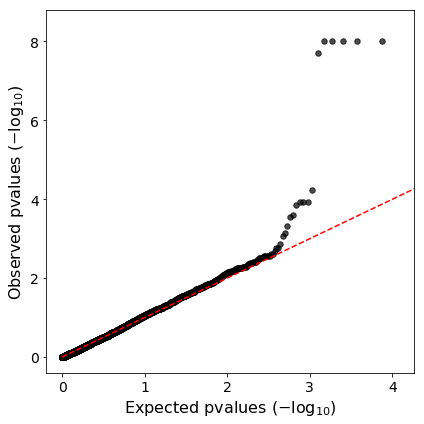

In [16]:
if type_run=="FM":
    fileout = "QQPLOT_FMDeg_TCGA.png"
else:
    fileout = "QQPLOT_SMDeg_TCGA.png"

qqplot = QQplot(df=df, ttype = "PAN_CANCER", frac=1., output_file=os.path.join(path_output_plots,fileout))

## Done!